<a href="https://colab.research.google.com/github/garbesc/Projet-6/blob/main/Classez_des_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import des librairies
import os, sys
import csv
import math, random
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report
from functools import partial

import tensorflow as tf
from tensorflow import keras
#import keras_cv
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils import load_img
from keras.utils import img_to_array
#import tensorrt as trt
%load_ext tensorboard


print("Tensorflow version " + tf.__version__)
print ("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

Tensorflow version 2.12.0
GPU available


In [ ]:
#!pip uninstall tensorflow-gpu
#!pip install tensorflow-gpu==2.8
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
#!pip install --upgrade --index-url https://pypi.ngc.nvidia.com nvidia-tensorrt
#!pip install keras-cv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_bench = pd.DataFrame(columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])

Fonctions communes aux traitements

In [6]:
# Création des jeux d'entrainement, valorisation et test
def create_datasets(foldername, img_height, img_width, batch_size ):

  train_path = "./" + foldername + "/train"
  val_path   = "./" + foldername + "/val"
  test_path  = "./" + foldername + "/test"
  # Constitution du jeu d'entrainement
  train_ds = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         labels='inferred',
                                                         label_mode='categorical',
                                                         seed=123,
                                                         image_size=(img_height, img_width),
                                                         batch_size=batch_size)

# Constitution du jeu de valorisation
  val_ds = tf.keras.utils.image_dataset_from_directory(val_path,
                                                       labels='inferred',
                                                       label_mode='categorical',
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

  # Constitution du jeu de test
  test_ds = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        seed=123,
                                                        image_size=(img_height, img_width),
                                                        batch_size=batch_size)
  # Vérification des formats
  #for image_batch, labels_batch in train_ds:
  #  print(image_batch.shape)
  #  print(labels_batch.shape)
  #  break
  return train_ds, val_ds, test_ds

In [3]:
def create_model(model_name,img_height, img_width) :
  DefaultConv2D = partial(layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")
  DefaultMaxPooling = partial(layers.MaxPooling2D, pool_size=(2,2), strides=(2,2))

  if model_name == "VGG16":
    model = Sequential([
      layers.Rescaling(1./255, input_shape=[img_height, img_width,3]),
      DefaultConv2D(filters=64),
      DefaultConv2D(filters=64),
      DefaultMaxPooling(),
      DefaultConv2D(filters=128),
      DefaultConv2D(filters=128),
      DefaultMaxPooling(),
      DefaultConv2D(filters=256),
      DefaultConv2D(filters=256),
      DefaultConv2D(filters=256),
      DefaultMaxPooling(),
      DefaultConv2D(filters=512),
      DefaultConv2D(filters=512),
      DefaultConv2D(filters=512),
      DefaultMaxPooling(),
      DefaultConv2D(filters=512),
      DefaultConv2D(filters=512),
      DefaultConv2D(filters=512),
      DefaultMaxPooling(),
      keras.layers.Flatten(),
      keras.layers.Dense(4096, activation='relu'),
      keras.layers.Dense(4096, activation='relu'),
      keras.layers.Dense(num_classes, activation = 'softmax')])
  return model

In [3]:
# Affichage des résulats (précision et fonction de perte)
def display_plots(history):
  plt.rcParams['figure.figsize'] = (6,6)

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, 'red', label='Training acc')
  plt.plot(epochs, val_acc, 'blue', label='Validation acc')
  plt.legend()

  plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, 'red', label='Training loss')
  plt.plot(epochs, val_loss, 'blue', label='Validation loss')

  plt.legend()

  plt.show()
  return

In [4]:
# Prédiction de l'image 'echantillon'
def predict_sample(img_height, img_width, model):

  img = tf.keras.utils.load_img(
    "/content/drive/MyDrive/OpenClassRooms/Projet n°6/data/snooky.jpg", target_size=[img_height, img_width])
  plt.imshow(img)
  input_array = np.reshape(img_to_array(img), (-1, img_height, img_width, 3)) / 255
  pred = model.predict(input_array)
  for idx in pred.argsort()[0][::-1][:5]:
    print("{:.2f}%".format(pred[0][idx]*100), "\t", class_names[idx].split("-")[-1])

  return

In [5]:
# Préparation des rappels
def describe_callbacks(model_name, foldername, img_height, img_width) :

  run_dir = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Run"
  log_dir = os.path.join(run_dir + "/logs/", model_name + "_" + foldername + "_" + str(img_height) + "x" + str(img_width))
  models_dir = os.path.join(run_dir + "/models/", model_name + "_" + foldername + "_" + str(img_height) + "x" + str(img_width))
  models_dir

  # Ecritures des journaux
  log_dir = os.path.join(run_dir + "/logs/", model_name + "_" + foldername + "_" + str(img_height) + "x" + str(img_width)) + "/"
  os.makedirs(log_dir, exist_ok=True)
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=log_dir, monitor='val_loss', verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq=1)

  # Sauvegarde du meilleur modele
  save_dir = run_dir + "/models/best-model.h5"
  bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

  # Arret préventif au bout de 3 passages sans amélioration de la précision
  stopmodel_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1)

  # Sauvegarde du modele aprés chaque passage
  save_dir = run_dir + "/models/model-{epoch:04d}.h5"
  savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

  #cleanmodel_callback = tf.keras.callbacks.BackupAndRestore(save_dir, save_freq="epoch", delete_checkpoint=True, save_before_preemption=False)

  path=os.path.abspath(f'{log_dir}/log_dir')
  print(f'To run tensorboard :\ntensorboard --logdir {log_dir}')
  return tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback

# Implementation du modele VGG 16 (from scratch)

## Jeu de données réduit à 12 races, images originales, taille 224x224

In [ ]:
%cd /content/drive/MyDrive/OpenClassRooms/Projet n°6/

/content/drive/MyDrive/OpenClassRooms/Projet n°6


In [ ]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 224
img_width = 224
epochs = 100
fit_verbosity=1

In [ ]:
foldername = "FewBreeds"
train_ds, val_ds, test_ds = create_datasets(foldername, img_height, img_width, batch_size )

# Etiquettes des classes cibles
class_names = train_ds.class_names
num_classes = len(class_names)
print (num_classes)

Found 1608 files belonging to 12 classes.
Found 315 files belonging to 12 classes.
Found 226 files belonging to 12 classes.
12


In [ ]:
# Création du modele type VGG16
model_name = "VGG16"
model = create_model(model_name,img_height, img_width)

In [ ]:
# Mise en cache pour accelerer les passages aux diffentes epochs
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/VGG16_FewBreeds_224x224/


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
t0 = time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100
51/51 [==============================] - 444s 3s/step - loss: 2.5139 - accuracy: 0.0989 - val_loss: 2.4785 - val_accuracy: 0.0984
Epoch 2/100
51/51 [==============================] - 21s 425ms/step - loss: 2.4793 - accuracy: 0.0970 - val_loss: 2.4763 - val_accuracy: 0.0984
Epoch 3/100
51/51 [==============================] - 27s 542ms/step - loss: 2.4794 - accuracy: 0.1001 - val_loss: 2.4760 - val_accuracy: 0.1016
Epoch 4/100
51/51 [==============================] - 22s 433ms/step - loss: 2.4780 - accuracy: 0.0914 - val_loss: 2.4758 - val_accuracy: 0.1016
Epoch 5/100
51/51 [==============================] - 27s 546ms/step - loss: 2.4785 - accuracy: 0.1014 - val_loss: 2.4760 - val_accuracy: 0.1016
Epoch 6/100
51/51 [==============================] - 66s 1s/step - loss: 2.4779 - accuracy: 0.1014 - val_loss: 2.4757 - val_accuracy: 0.1016
Epoch 7/100
51/51 [==============================] - 22s 447ms/step - loss: 2.4773 - accuracy: 0.1014 - val_loss: 2.4757 - val_accuracy: 0.10

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
df_res

Max validation accuracy is : 0.1016


Modele     Folder   Format  Durée  Accuracy  Epoch_max
0  VGG16  FewBreeds  224x224   17.0  0.101587         25

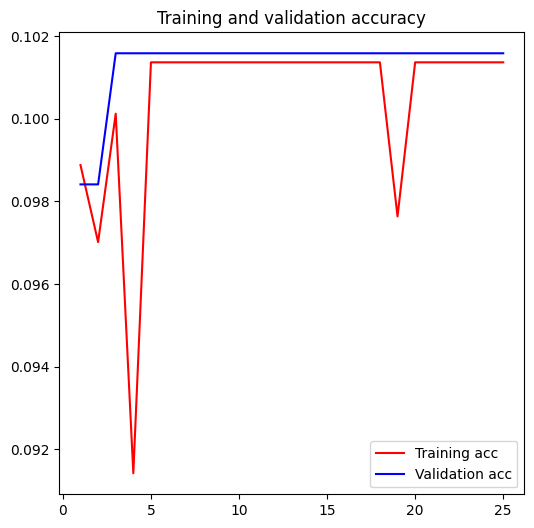

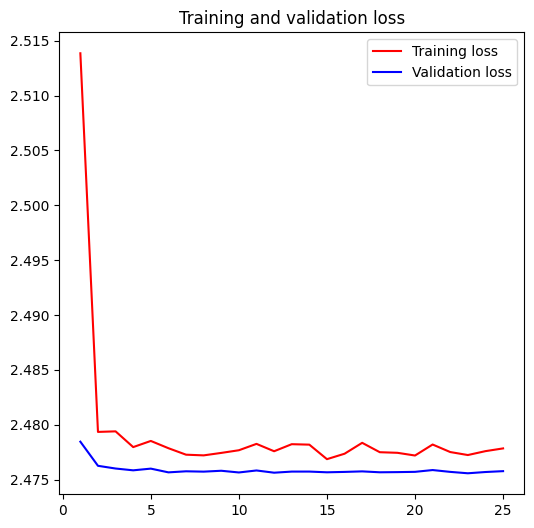

In [ ]:
display_plots(history)

1/1 [==============================] - 0s 368ms/step
10.29% 	 Samoyed
9.88% 	 Great_Pyrenees
9.40% 	 Leonberg
9.39% 	 Siberian_husky
9.15% 	 Newfoundland


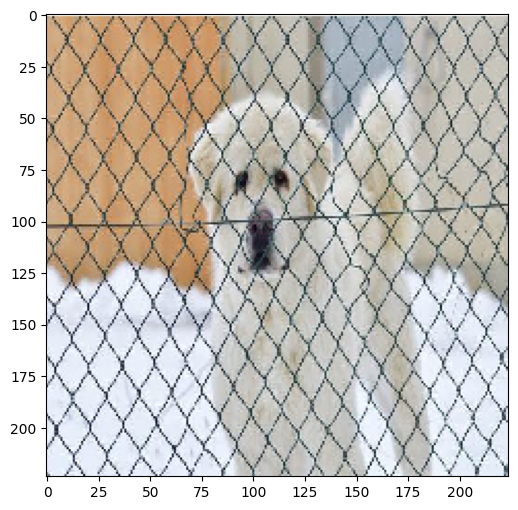

In [ ]:
predict_sample(img_height, img_width, model)

In [ ]:
#loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/models/best-model.h5")
# Chargement du meilleur modele
bestmodel = tf.keras.models.load_model("/content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/models/last-model.h5")



results = bestmodel.evaluate(x=val_ds, batch_size= batch_size)
#print(f"test loss, test acc: {results}")

10/10 [==============================] - 146s 739ms/step - loss: 2.4758 - accuracy: 0.1016


In [ ]:
train_path = "./" + foldername + "/train"
val_path   = "./" + foldername + "/val"
test_path  = "./" + foldername + "/test"

train_batch = ImageDataGenerator(featurewise_center=False,
                                 samplewise_center=False,
                                 featurewise_std_normalization=False,
                                 samplewise_std_normalization=False,
                                 zca_whitening=False,
                                 rotation_range=45,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=False).flow_from_directory(train_path,
                                                                          target_size=(img_height, img_width),
                                                                          class_mode="categorical",
                                                                          shuffle=None,
                                                                          batch_size=batch_size)

val_batch = ImageDataGenerator().flow_from_directory(val_path,
                                                      target_size=(img_height, img_width),
                                                      class_mode="categorical",
                                                      shuffle=None,
                                                      batch_size=batch_size)

Found 1608 images belonging to 12 classes.
Found 315 images belonging to 12 classes.


## Jeu de données réduit à 12 races, images originales, taille 180x180

In [ ]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 180
img_width = 180
epochs = 100
fit_verbosity=1

In [ ]:
foldername = "FewBreeds"
train_ds, val_ds, test_ds = create_datasets(foldername, img_height, img_width, batch_size )

# Etiquettes des classes cibles
class_names = train_ds.class_names
num_classes = len(class_names)
print (num_classes)

Found 1608 files belonging to 12 classes.
Found 315 files belonging to 12 classes.
Found 226 files belonging to 12 classes.
12


In [ ]:
# Création du modele type VGG16
model_name = "VGG16"
model = create_model(model_name,img_height, img_width)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       147584    
                                                        

In [ ]:
# Mise en cache pour accelerer les passages aux diffentes epochs
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)


To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/VGG16_FewBreeds_180x180/


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
t0 = time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100
51/51 [==============================] - 35s 691ms/step - loss: 2.4769 - accuracy: 0.0951 - val_loss: 2.4756 - val_accuracy: 0.1016
Epoch 2/100
51/51 [==============================] - 37s 730ms/step - loss: 2.4769 - accuracy: 0.0920 - val_loss: 2.4757 - val_accuracy: 0.1016
Epoch 3/100
51/51 [==============================] - 37s 735ms/step - loss: 2.4768 - accuracy: 0.0927 - val_loss: 2.4756 - val_accuracy: 0.1016
Epoch 4/100
51/51 [==============================] - 38s 745ms/step - loss: 2.4768 - accuracy: 0.1014 - val_loss: 2.4755 - val_accuracy: 0.1016
Epoch 5/100
51/51 [==============================] - 37s 724ms/step - loss: 2.4769 - accuracy: 0.1014 - val_loss: 2.4756 - val_accuracy: 0.1016
Epoch 6/100
51/51 [==============================] - 38s 747ms/step - loss: 2.4765 - accuracy: 0.1014 - val_loss: 2.4755 - val_accuracy: 0.1016
Epoch 7/100
51/51 [==============================] - 40s 786ms/step - loss: 2.4768 - accuracy: 0.1014 - val_loss: 2.4756 - val_accuracy:

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
df_res

Max validation accuracy is : 0.1016


Modele     Folder   Format  Durée  Accuracy  Epoch_max
0  VGG16  FewBreeds  180x180   22.0  0.101587         16

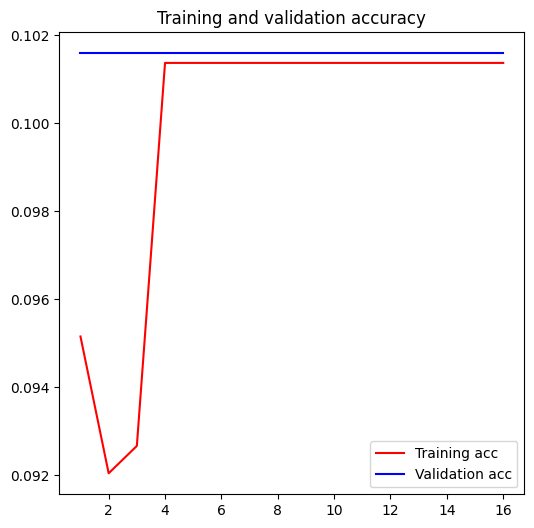

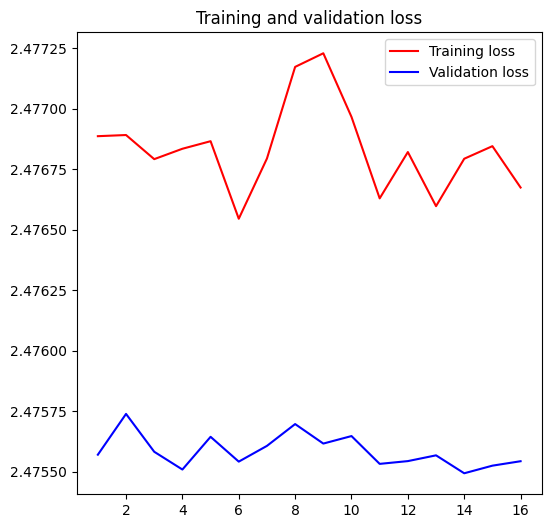

In [ ]:
display_plots(history)

1/1 [==============================] - 1s 872ms/step
9.97% 	 Samoyed
9.74% 	 Great_Pyrenees
9.65% 	 Leonberg
9.10% 	 Newfoundland
8.85% 	 Siberian_husky


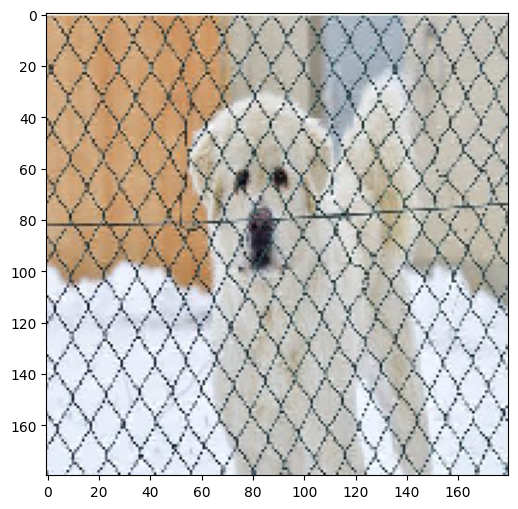

In [ ]:
predict_sample(img_height, img_width, model)

In [ ]:
pd.DataFrame(df_bench).to_csv('./Run/models/bench_models.csv', index=False)

## Jeu de données réduit à 12 races, images recadrées, taille 180x180

In [ ]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 180
img_width = 180
epochs = 100
fit_verbosity=1

In [ ]:
foldername = "FewCroppedImages"
train_ds, val_ds, test_ds = create_datasets(foldername, img_height, img_width, batch_size )

# Etiquettes des classes cibles
class_names = train_ds.class_names
num_classes = len(class_names)
print (num_classes)
train_path = "./" + foldername + "/train"
val_path   = "./" + foldername + "/val"
test_path  = "./" + foldername + "/test"

Found 1594 files belonging to 12 classes.
Found 312 files belonging to 12 classes.
Found 225 files belonging to 12 classes.
12


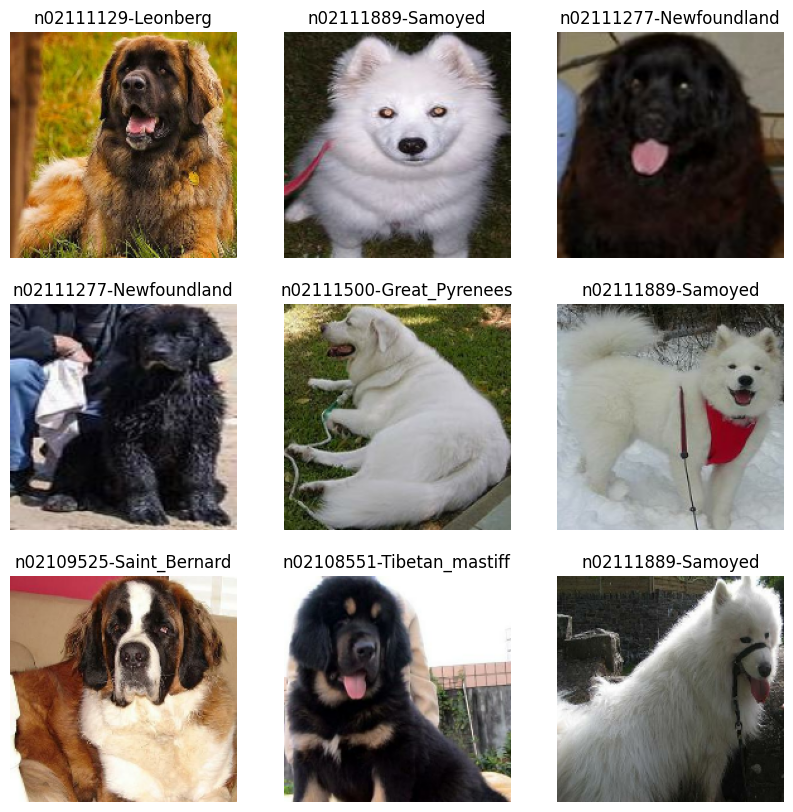

In [ ]:
# Visualisation des images d'origine
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.where(labels[i].numpy() == 1)[0][0]])
        plt.axis("off")

In [ ]:
# Création du modele type VGG16
model_name = "VGG16"
model = create_model(model_name,img_height, img_width)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       147584    
                                                        

In [ ]:
# Mise en cache pour accelerer les passages aux diffentes epochs
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/VGG16_FewCroppedImages_180x180/


In [ ]:
#%tensorboard --logdir="/content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/VGG16_FewCroppedImages_180x180/"

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
t0=time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)
#model.save(f'{run_dir}/models/last-model.h5')

Epoch 1/100
50/50 [==============================] - 616s 3s/step - loss: 2.4937 - accuracy: 0.0928 - val_loss: 2.4768 - val_accuracy: 0.0994
Epoch 2/100
50/50 [==============================] - 19s 392ms/step - loss: 2.4792 - accuracy: 0.0991 - val_loss: 2.4791 - val_accuracy: 0.0994
Epoch 3/100
50/50 [==============================] - 19s 388ms/step - loss: 2.4797 - accuracy: 0.0878 - val_loss: 2.4756 - val_accuracy: 0.1026
Epoch 4/100
50/50 [==============================] - 25s 514ms/step - loss: 2.4784 - accuracy: 0.0935 - val_loss: 2.4756 - val_accuracy: 0.1026
Epoch 5/100
50/50 [==============================] - 24s 494ms/step - loss: 2.4776 - accuracy: 0.1023 - val_loss: 2.4755 - val_accuracy: 0.1026
Epoch 6/100
50/50 [==============================] - 25s 517ms/step - loss: 2.4789 - accuracy: 0.0928 - val_loss: 2.4758 - val_accuracy: 0.1026
Epoch 7/100
50/50 [==============================] - 39s 789ms/step - loss: 2.4781 - accuracy: 0.1023 - val_loss: 2.4754 - val_accuracy: 0

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
df_res

Max validation accuracy is : 0.1026


Modele            Folder   Format  Durée  Accuracy  Epoch_max
0  VGG16  FewCroppedImages  180x180   36.0  0.102564        100

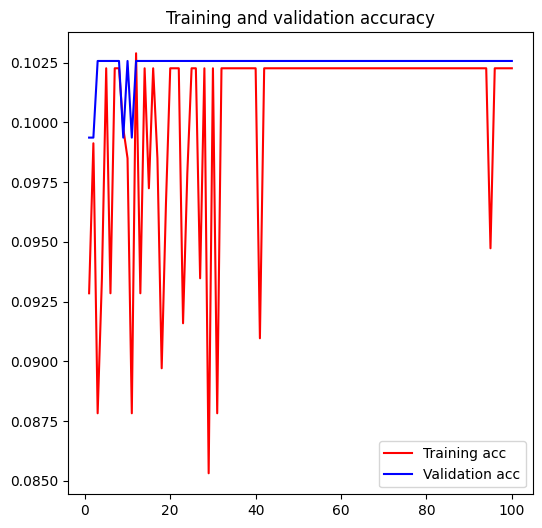

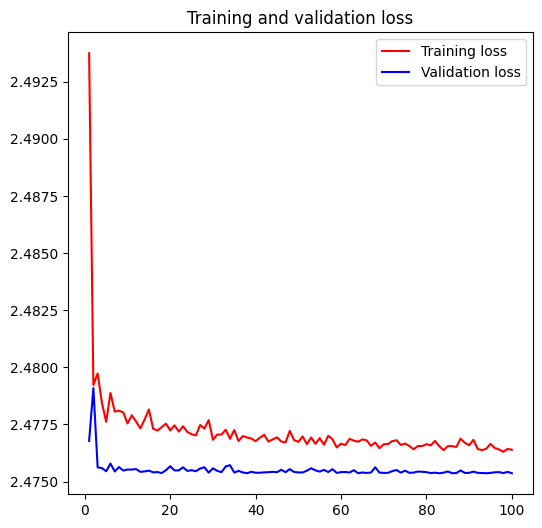

In [ ]:
display_plots(history)

1/1 [==============================] - 1s 630ms/step
10.25% 	 Samoyed
9.91% 	 Leonberg
9.89% 	 Great_Pyrenees
9.21% 	 Newfoundland
8.37% 	 Siberian_husky


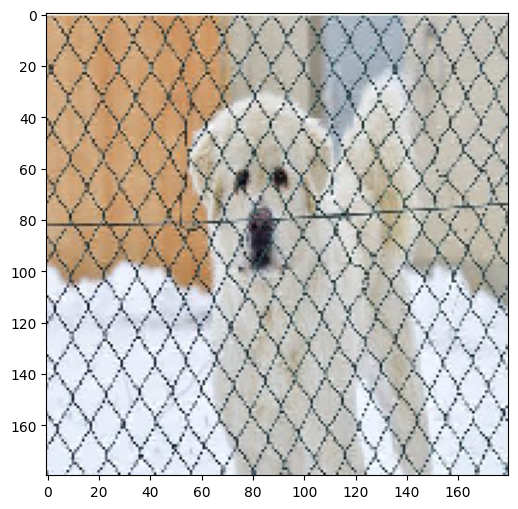

In [ ]:
predict_sample(img_height, img_width, model)

In [ ]:
pd.DataFrame(df_bench).to_csv('./Run/models/bench_models.csv', index=False)

Test VGG16 avec modification de l'optimizer

In [ ]:
model.compile(optimizer='rmsprop'', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Execution du modele
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback])

model.save(f'.Run/models/last-model.h5')

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.1009


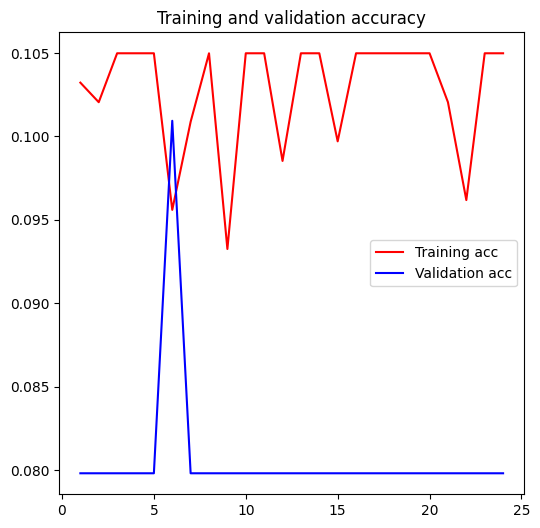

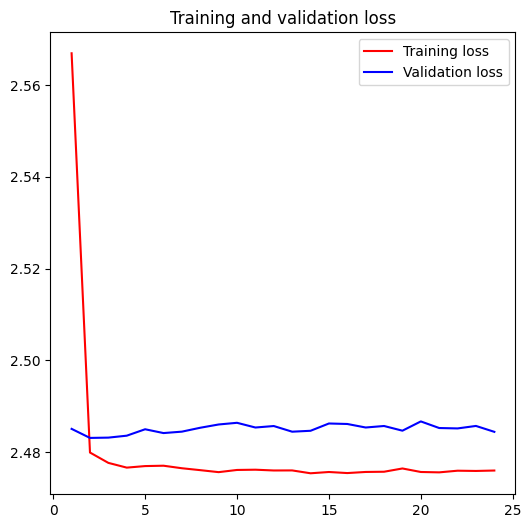

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

1/1 [==============================] - 1s 735ms/step
10.25% 	 Great_Pyrenees
10.06% 	 Samoyed
9.35% 	 Leonberg
9.19% 	 Newfoundland
8.14% 	 Siberian_husky


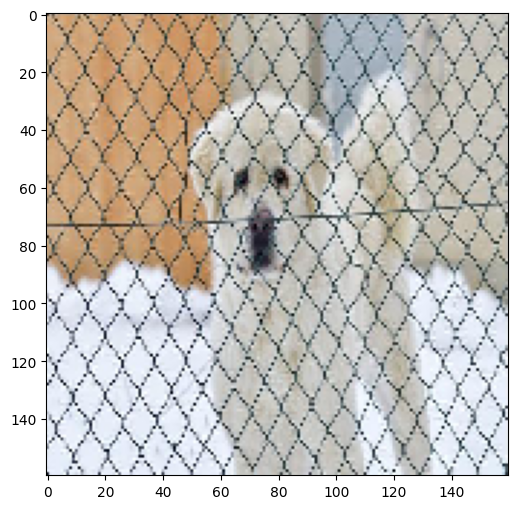

In [ ]:
img = tf.keras.utils.load_img(
    "/content/drive/MyDrive/OpenClassRooms/Projet n°6/data/snooky.jpg", target_size=[img_height, img_width]
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

pred = model.predict(img_array)
for idx in pred.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(pred[0][idx]*100), "\t", class_names[idx].split("-")[-1])
#print(class_names[np.argmax(pred)])


## Jeu de données réduit à 12 races, images preprocessées et augmentées, taille 180x180

In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

./FewBreedsImages/train/n02108551-Tibetan_mastiff/n02108551_4769.jpg


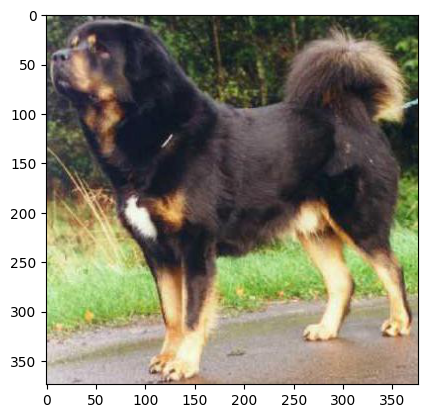

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True)
random_path = train_path + "/" + random.choice(os.listdir(train_path))
random_image= random_path + "/" + random.choice(os.listdir(random_path))
print (random_image)
image = np.expand_dims(plt.imread(random_image),0)
plt.imshow(image[0])

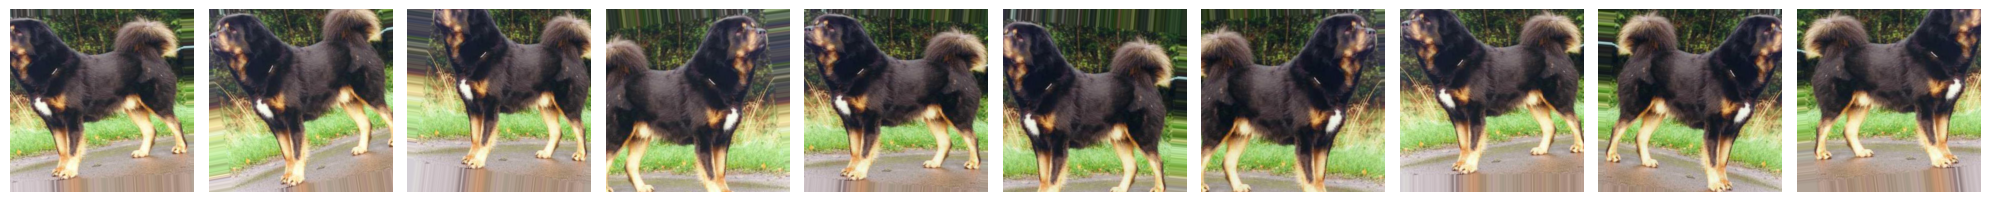

In [ ]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plotImages(aug_images)

In [ ]:
#aug_iter = gen.flow(image, save_to_dir='data/dogs-vs-cats/train/dog', save_prefix='aug-image-', save_format='jpeg')

In [ ]:
import random

def preprocess(img, label):
    img = tf.image.resize(img, (img_height, img_width))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.cast(img, tf.float32)
    label = tf.one_hot(label, 12)
    return {"images": img, "labels": label}

def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

def cutmix_or_mixup(samples):
    if tf.random.uniform(()) > 0.5:
        samples = keras_cv.layers.CutMix()(samples)
    else:
        samples = keras_cv.layers.MixUp()(samples)
    return samples

In [ ]:
value_range = (0, 255)

data_aug_pipeline = keras.Sequential([
    # magnitude sets how 'aggressive' the augmentations are
    keras_cv.layers.RandAugment(value_range=value_range, magnitude=0.3),
    keras_cv.layers.Equalization(value_range=value_range, bins=256),
    layers.RandomFlip(mode="horizontal_and_vertical", seed=None),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.2, value_range=(0, 255), seed=None),
    layers.RandomContrast(factor=0.4, seed=None)
])

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from functools import partial

DefaultConv2D = partial(layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")
DefaultMaxPooling = partial(layers.MaxPooling2D, pool_size=(2,2), strides=(2,2))

model = Sequential([
        layers.Rescaling(1./255, input_shape=[img_height, img_width,3]),
        data_aug_pipeline,
        DefaultConv2D(filters=64),
        DefaultConv2D(filters=64),
        DefaultMaxPooling(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        DefaultMaxPooling(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(num_classes, activation = 'softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# ---- Callback ModelCheckpoint - Save best mode
run_dir = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/"

# ---- Callback tensorboard
log_dir = run_dir + "/logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - stop the training when there is no improvement
stopmodel_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

#cleanmodel_callback = tf.keras.callbacks.BackupAndRestore(save_dir, save_freq="epoch", delete_checkpoint=True, save_before_preemption=False)

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
#  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100
50/50 [==============================] - 89s 1s/step - loss: 15.9380 - accuracy: 0.0891 - val_loss: 2.4767 - val_accuracy: 0.0994
Epoch 2/100
50/50 [==============================] - 38s 774ms/step - loss: 2.5074 - accuracy: 0.1016 - val_loss: 2.4759 - val_accuracy: 0.0994
Epoch 3/100
50/50 [==============================] - 28s 559ms/step - loss: 2.4789 - accuracy: 0.0935 - val_loss: 2.4757 - val_accuracy: 0.0994
Epoch 4/100
50/50 [==============================] - 27s 538ms/step - loss: 2.4779 - accuracy: 0.0966 - val_loss: 2.4759 - val_accuracy: 0.0994
Epoch 5/100
50/50 [==============================] - 27s 536ms/step - loss: 2.4782 - accuracy: 0.0997 - val_loss: 2.4755 - val_accuracy: 0.1026
Epoch 6/100
50/50 [==============================] - 29s 575ms/step - loss: 2.4782 - accuracy: 0.0972 - val_loss: 2.4766 - val_accuracy: 0.1026
Epoch 7/100
50/50 [==============================] - 31s 619ms/step - loss: 2.4781 - accuracy: 0.0922 - val_loss: 2.4756 - val_accuracy: 0

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

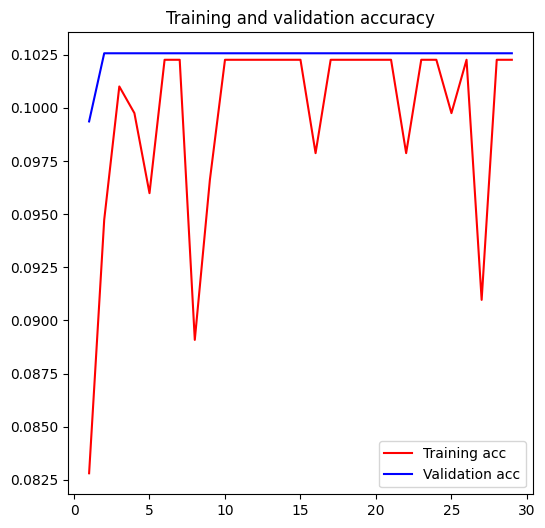

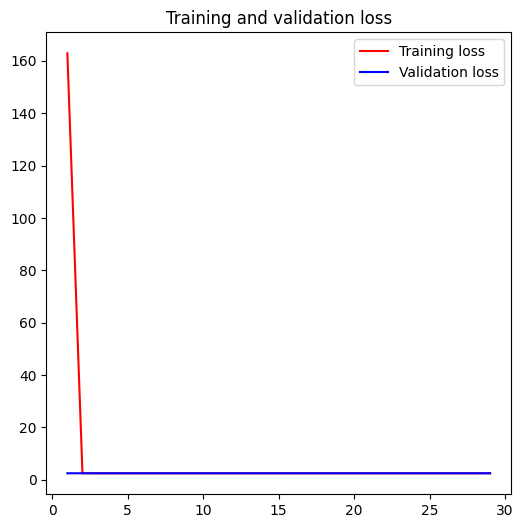

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
#  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100
50/50 [==============================] - 44s 665ms/step - loss: 2.4821 - accuracy: 0.0878 - val_loss: 2.4756 - val_accuracy: 0.1026
Epoch 2/100
50/50 [==============================] - 30s 598ms/step - loss: 2.4793 - accuracy: 0.0928 - val_loss: 2.4765 - val_accuracy: 0.0994
Epoch 3/100
50/50 [==============================] - 29s 582ms/step - loss: 2.4796 - accuracy: 0.0941 - val_loss: 2.4759 - val_accuracy: 0.1026
Epoch 4/100
50/50 [==============================] - 29s 582ms/step - loss: 2.4787 - accuracy: 0.0947 - val_loss: 2.4755 - val_accuracy: 0.1026
Epoch 5/100
50/50 [==============================] - 29s 590ms/step - loss: 2.8054 - accuracy: 0.0966 - val_loss: 2.4755 - val_accuracy: 0.0994
Epoch 6/100
50/50 [==============================] - 29s 586ms/step - loss: 2.4785 - accuracy: 0.0872 - val_loss: 2.4756 - val_accuracy: 0.1026
Epoch 7/100
50/50 [==============================] - 29s 588ms/step - loss: 2.4786 - accuracy: 0.0935 - val_loss: 2.4754 - val_accuracy:

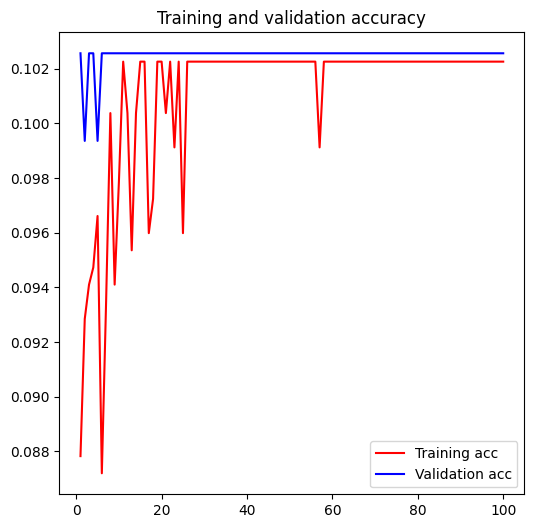

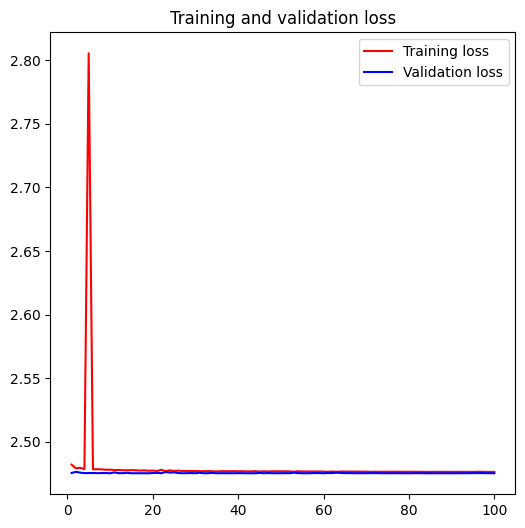

In [ ]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
# Chargement du meilleur modele
bestmodel = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')

results = bestmodel.evaluate(x=test_ds, batch_size= batch_size)
print(f"test loss, test acc: {results}")

8/8 [==============================] - 115s 10s/step - loss: 2.4756 - accuracy: 0.1022
test loss, test acc: [2.4755923748016357, 0.10222221910953522]


L'exécution du meilleur modèle sur le jeu de données de test confirme la probabilité de prédire correctement la bonne image (10%)

## Jeu de données réduit à 12 races, images augmentées par ZCA whitening

In [ ]:
%cd /content/drive/MyDrive/OpenClassRooms/Projet n°6/

/content/drive/MyDrive/OpenClassRooms/Projet n°6


In [ ]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 180
img_width = 180
epochs = 100
fit_verbosity=1
train_path = "./FewBreeds/train/"
val_path = "./FewBreeds/val/"
num_classes = 12

In [ ]:
#train_datagen = ImageDataGenerator(featurewise_center=True,
#                                    featurewise_std_normalization=True,
#                                    zca_whitening=True,rescale= 1./255)
#valid_datagen = ImageDataGenerator(rescale= 1./255)
train_datagen = ImageDataGenerator(validation_split=0.2)
valid_datagen = ImageDataGenerator(validation_split = 0.2)

In [ ]:
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle= None,
    subset='training'
)

val_ds = valid_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle= None,
    subset='validation'
)

Found 1293 images belonging to 12 classes.
Found 315 images belonging to 12 classes.


In [ ]:
X_train, y_train = train_ds.next()
X_test, y_test = val_ds.next()

In [ ]:
X = X_train[:1000]
X.shape

(32, 180, 180, 3)

In [ ]:
def plotImage(X):
    X = X/125
    plt.figure(figsize=(3, 3))
    plt.imshow(X.reshape(180,180,3))
    plt.show()
    plt.close()

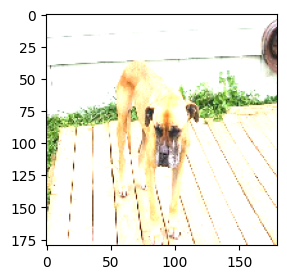

In [ ]:
plotImage(X[12])

In [ ]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
print (X.shape)

(32, 97200)


In [ ]:
X_norm = X / 255.
print ('X.min()', X_norm.min())
print ('X.max()', X_norm.max())

X.min() 0.0
X.max() 1.0


In [ ]:
X_norm = X_norm - X_norm.mean(axis=0)

In [ ]:
cov = np.cov(X_norm, rowvar=False)

In [ ]:
U,S,V = np.linalg.svd(cov)

In [ ]:
epsilon = 0.1
X_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(X_norm.T).T

In [ ]:
X_ZCA_rescaled = (X_ZCA - X_ZCA.min()) / (X_ZCA.max() - X_ZCA.min())
print ('min:', X_ZCA_rescaled.min())
print ('max:', X_ZCA_rescaled.max())

min: 0.0
max: 1.0


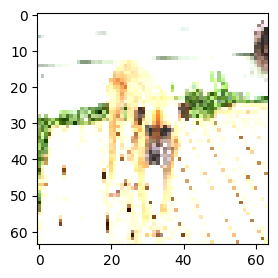

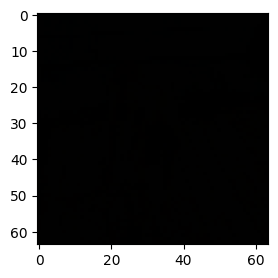

In [ ]:
plotImage(X[12, :])
plotImage(X_ZCA_rescaled[12, :])

In [ ]:
# Création du modele type VGG16
model_name = "VGG16"
model = create_model(model_name,img_height, img_width)

In [ ]:
foldername = "FewBreedswhit"
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/VGG16_FewBreedswhit_64x64/


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
t0 = time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


InvalidArgumentError: ignored

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
bench_file = './Run/models/bench_models.csv'
df_bench = pd.read_csv(bench_file)
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
pd.DataFrame(df_bench).to_csv(bench_file, index=False)
df_res

In [ ]:
display_plots(history)

In [ ]:
predict_sample(img_height, img_width, model)

# Transfer learning
Le dataset Stanford Dog étant issu d'ImageNet, les caractéristiques propres à chaque race de chiens ont été apprises lors du pré-entrainement. Le modèle sera donc repris en gelant les couches convolutives.


## Jeu de données réduit à 12 races, images originales, taille 224x224

In [ ]:
foldername = "FewBreeds"
train_ds, val_ds, test_ds = create_datasets(foldername, img_height, img_width, batch_size )

# Etiquettes des classes cibles
class_names = train_ds.class_names
num_classes = len(class_names)
print (num_classes)

Found 1608 files belonging to 12 classes.
Found 315 files belonging to 12 classes.
Found 226 files belonging to 12 classes.
12


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
VGG16_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in VGG16_model.layers:
  layer.trainable = False

VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Modification des couches de sortie
x= keras.layers.Flatten()(VGG16_model.output)
prediction = keras.layers.Dense(num_classes,  activation = 'softmax') (x)

# création du modele global
model_name = "VGG16+"
new_model = Model(inputs=VGG16_model.input, outputs=prediction)
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Ecritures des journaux
run_dir = "/content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/"
log_dir = os.path.join(run_dir + "/logs/", model_name + "_" + foldername + "_" + str(img_height) + "x" + str(img_width)) + "/"
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Sauvegarde du meilleur modele
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# Arret préventif au bout de 10 passages sans amélioration de la précision
stopmodel_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)

# Sauvegarde du modele aprés chaque passage
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

#cleanmodel_callback = tf.keras.callbacks.BackupAndRestore(save_dir, save_freq="epoch", delete_checkpoint=True, save_before_preemption=False)

path=os.path.abspath(f'{log_dir}/log_dir')
print(f'To run tensorboard :\ntensorboard --logdir {log_dir}')

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run//logs/VGG16+_FewBreeds_224x224/


In [ ]:
adamOpti = Adam(learning_rate=0.001)
new_model.compile(optimizer = adamOpti, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
%%time
t0=time()
history = new_model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback])

new_model.save(f'{run_dir}/models/last-model.h5')

Epoch 1/100
51/51 [==============================] - 10s 108ms/step - loss: 23.8181 - accuracy: 0.5006 - val_loss: 19.4181 - val_accuracy: 0.6444
Epoch 2/100
51/51 [==============================] - 4s 80ms/step - loss: 3.6978 - accuracy: 0.8974 - val_loss: 21.0183 - val_accuracy: 0.6444
Epoch 3/100
51/51 [==============================] - 4s 75ms/step - loss: 1.8047 - accuracy: 0.9415 - val_loss: 23.1562 - val_accuracy: 0.6603
Epoch 4/100
51/51 [==============================] - 4s 83ms/step - loss: 1.1266 - accuracy: 0.9652 - val_loss: 22.5519 - val_accuracy: 0.6476
Epoch 5/100
51/51 [==============================] - 4s 74ms/step - loss: 1.0357 - accuracy: 0.9658 - val_loss: 19.9183 - val_accuracy: 0.6603
Epoch 6/100
51/51 [==============================] - 4s 74ms/step - loss: 0.7725 - accuracy: 0.9739 - val_loss: 26.4509 - val_accuracy: 0.6476
Epoch 7/100
51/51 [==============================] - 4s 79ms/step - loss: 0.9593 - accuracy: 0.9658 - val_loss: 31.5074 - val_accuracy: 0.6

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
bench_file = './Run/models/bench_models.csv'
df_bench = pd.read_csv(bench_file)
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
pd.DataFrame(df_bench).to_csv(bench_file, index=False)
df_res

Max validation accuracy is : 0.0825


Modele     Folder   Format  Durée  Accuracy  Epoch_max
0  VGG16aug  FewBreeds  224x224   22.0   0.08254         39

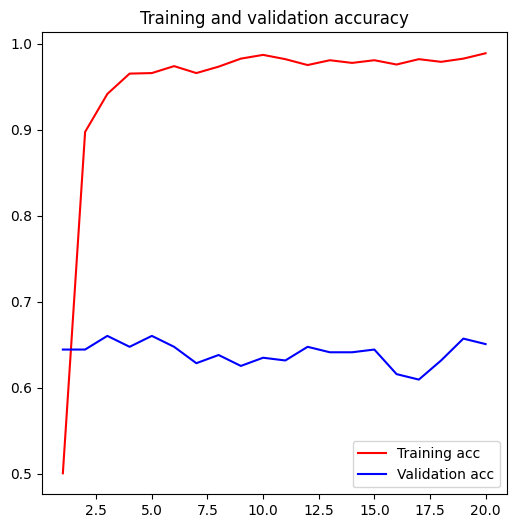

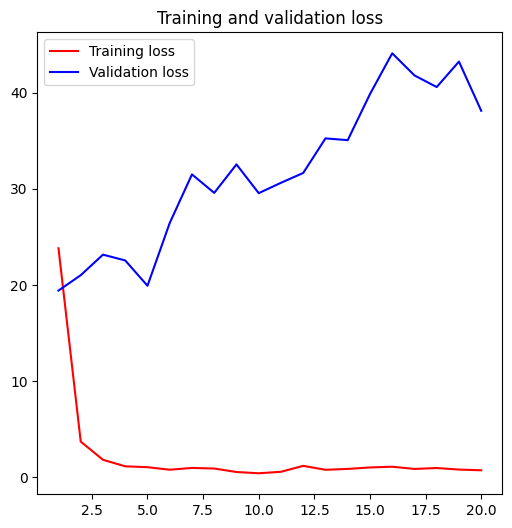

In [ ]:
display_plots(history)

1/1 [==============================] - 0s 374ms/step
100.00% 	 Siberian_husky
0.00% 	 Samoyed
0.00% 	 Great_Pyrenees
0.00% 	 Newfoundland
0.00% 	 Leonberg


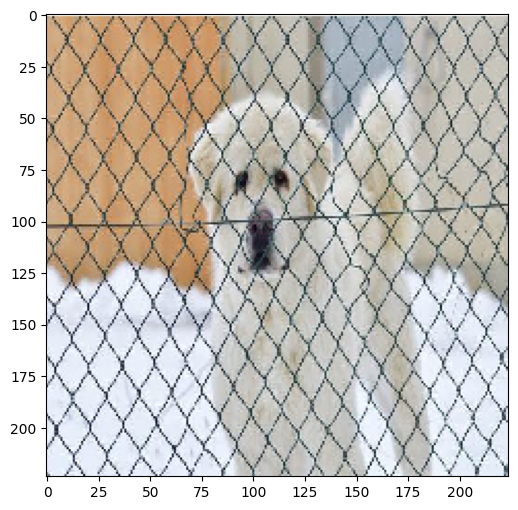

In [ ]:
predict_sample(img_height, img_width, new_model)

## Transfer learning avec augmentation de données

In [ ]:
%cd /content/drive/MyDrive/OpenClassRooms/Projet n°6/

/content/drive/MyDrive/OpenClassRooms/Projet n°6


In [ ]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 224
img_width = 224
epochs = 100
fit_verbosity=1
train_path = "./FewCroppedImages/train"
val_path = "./FewCroppedImages/val"
model_name = "VGG16aug"
num_classes=12

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2)

valid_datagen = ImageDataGenerator(
    rescale= 1./255)

In [ ]:
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle= None,
    seed= 1337
)

val_ds = valid_datagen.flow_from_directory(
    val_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle= None,
    seed= 1337
)

Found 1594 images belonging to 12 classes.
Found 312 images belonging to 12 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height,3))

for layer in base_model.layers:
  layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
x = keras.layers.BatchNormalization()(base_model.output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
foldername = 'FewCroppedImages'
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/VGG16aug_FewCroppedImages_224x224/


In [ ]:
adamOpti = Adam(learning_rate=0.0001)
model.compile(optimizer = adamOpti, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
%%time
t0 = time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100
50/50 [==============================] - 499s 10s/step - loss: 2.6467 - accuracy: 0.0703 - val_loss: 2.5156 - val_accuracy: 0.0545
Epoch 2/100
50/50 [==============================] - 24s 476ms/step - loss: 2.5785 - accuracy: 0.0928 - val_loss: 2.4926 - val_accuracy: 0.0769
Epoch 3/100
50/50 [==============================] - 23s 455ms/step - loss: 2.5940 - accuracy: 0.0853 - val_loss: 2.4742 - val_accuracy: 0.0962
Epoch 4/100
50/50 [==============================] - 23s 467ms/step - loss: 2.5399 - accuracy: 0.1079 - val_loss: 2.4577 - val_accuracy: 0.1218
Epoch 5/100
50/50 [==============================] - 23s 462ms/step - loss: 2.5696 - accuracy: 0.0872 - val_loss: 2.4335 - val_accuracy: 0.1571
Epoch 6/100
50/50 [==============================] - 23s 457ms/step - loss: 2.5404 - accuracy: 0.0903 - val_loss: 2.4134 - val_accuracy: 0.1891
Epoch 7/100
50/50 [==============================] - 23s 456ms/step - loss: 2.5577 - accuracy: 0.0903 - val_loss: 2.3883 - val_accuracy: 

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
bench_file = './Run/models/bench_models.csv'
df_bench = pd.read_csv(bench_file)
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
pd.DataFrame(df_bench).to_csv(bench_file, index=False)
df_res

Max validation accuracy is : 0.0825


Modele     Folder   Format  Durée  Accuracy  Epoch_max
0  VGG16aug  FewBreeds  224x224   29.0   0.08254         39

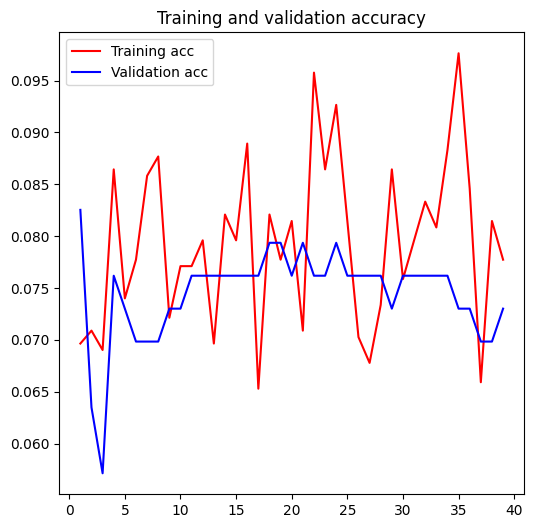

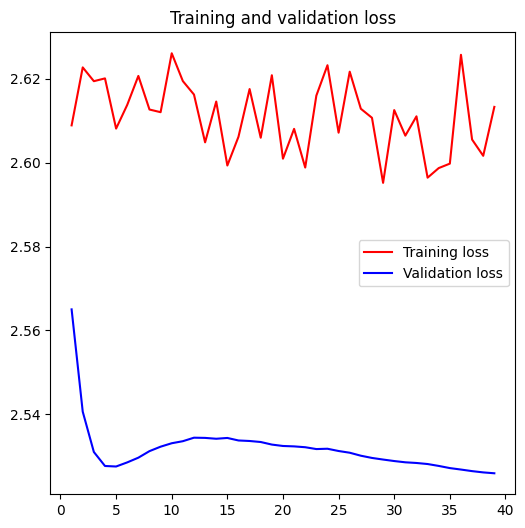

In [ ]:
display_plots(history)

In [ ]:
#Confution Matrix and Classification Report
num_of_train_samples = 1608
num_of_test_samples = 315
Y_pred = model.predict_generator(val_ds, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_ds.classes, y_pred))
print('Classification Report')
target_names = list(train_ds.class_indices.keys())
print(classification_report(val_ds.classes, y_pred, target_names=target_names))

<ipython-input-40-253bd2e34e4f>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_ds, num_of_test_samples // batch_size+1)


Confusion Matrix
[[ 1  0  1  1  3  5  0 10  1  1  0  0]
 [ 3  0  2  2  0  1  2  9  0  3  0  0]
 [ 0  0  4  3  3  3  1  8  0  1  0  0]
 [ 2  0  0  2  0  3  0 14  2  0  0  0]
 [ 1  0  4  2  0  3  0 12  1  2  0  0]
 [ 0  0  3  3  1  4  3  8  0  0  0  0]
 [ 1  0  1  2  0  3  1 12  0  2  4  0]
 [ 1  0  3  2  0  5  1 10  2  1  3  0]
 [ 4  2  2  5  0  0  0 16  0  1  1  0]
 [ 1  0  0  5  0  3  2 17  1  0  0  0]
 [ 3  0  0  2  2  2  1 15  2  3  1  0]
 [ 4  0  2  0  0  4  3 15  3  0  1  0]]
Classification Report
                           precision    recall  f1-score   support

   n02108422-bull_mastiff       0.05      0.04      0.05        23
n02108551-Tibetan_mastiff       0.00      0.00      0.00        22
 n02108915-French_bulldog       0.18      0.17      0.18        23
     n02109047-Great_Dane       0.07      0.09      0.08        23
  n02109525-Saint_Bernard       0.00      0.00      0.00        25
     n02109961-Eskimo_dog       0.11      0.18      0.14        22
       n02110063-malam

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Transfer learning avec rétropropagation pour mettre à jour les deux dernières couches pré-entraînées.

In [ ]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 224
img_width = 224
epochs = 25
fit_verbosity=1

In [ ]:
%cd /content/drive/MyDrive/OpenClassRooms/Projet n°6/

/content/drive/MyDrive/OpenClassRooms/Projet n°6


In [ ]:
foldername = "FewBreeds"
train_ds, val_ds, test_ds = create_datasets(foldername, img_height, img_width, batch_size )

# Etiquettes des classes cibles
class_names = train_ds.class_names
num_classes = len(class_names)
print (num_classes)

Found 1608 files belonging to 12 classes.
Found 315 files belonging to 12 classes.
Found 226 files belonging to 12 classes.
12


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# Création du modele en laissant cette fois les 2 dernières couches non gelées pour le réglage fin
model_name = "VGG16FT2"
fine_tune = 2

conv_base = VGG16(include_top=False, weights='imagenet', input_shape=[img_height, img_width,3])
for layer in conv_base.layers[:-fine_tune]:
  layer.trainable = False

# Modification des couches de sortie
x= Flatten()(conv_base.output)
prediction = Dense(num_classes,  activation = 'softmax') (x)

# création du modele global
model = Model(inputs=conv_base.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Mise en cache pour accelerer les passages aux diffentes epochs
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/VGG16FT2_FewBreeds_224x224/


In [ ]:
adamOpti = Adam(learning_rate=0.0001)
model.compile(optimizer = adamOpti, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
%%time
t0 = time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100
51/51 [==============================] - 212s 1s/step - loss: 12.8620 - accuracy: 0.4515 - val_loss: 3.6415 - val_accuracy: 0.6127
Epoch 2/100
51/51 [==============================] - 12s 245ms/step - loss: 0.4617 - accuracy: 0.9384 - val_loss: 2.2864 - val_accuracy: 0.6667
Epoch 3/100
51/51 [==============================] - 13s 265ms/step - loss: 0.1068 - accuracy: 0.9845 - val_loss: 2.2382 - val_accuracy: 0.6603
Epoch 4/100
51/51 [==============================] - 14s 281ms/step - loss: 0.0523 - accuracy: 0.9913 - val_loss: 2.3086 - val_accuracy: 0.6730
Epoch 5/100
51/51 [==============================] - 15s 292ms/step - loss: 0.0252 - accuracy: 0.9963 - val_loss: 2.3043 - val_accuracy: 0.6349
Epoch 6/100
51/51 [==============================] - 14s 276ms/step - loss: 0.0392 - accuracy: 0.9975 - val_loss: 2.2401 - val_accuracy: 0.6667
Epoch 7/100
51/51 [==============================] - 8s 167ms/step - loss: 0.0202 - accuracy: 0.9975 - val_loss: 2.2348 - val_accuracy: 0

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
bench_file = './Run/models/bench_models.csv'
df_bench = pd.read_csv(bench_file)
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
pd.DataFrame(df_bench).to_csv(bench_file, index=False)
df_res

Max validation accuracy is : 0.6889


Modele     Folder   Format  Durée  Accuracy  Epoch_max
0  VGG16FT2  FewBreeds  224x224   11.0  0.688889         36

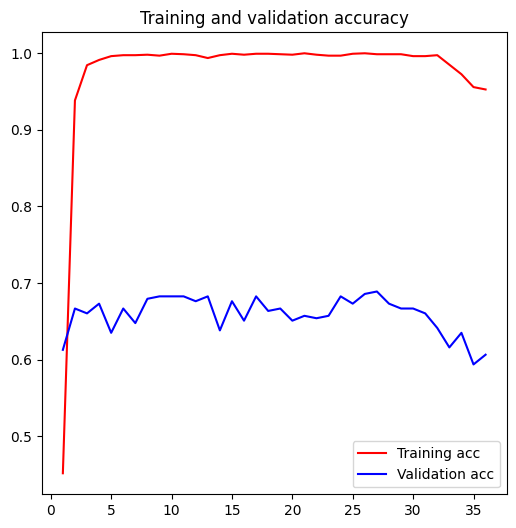

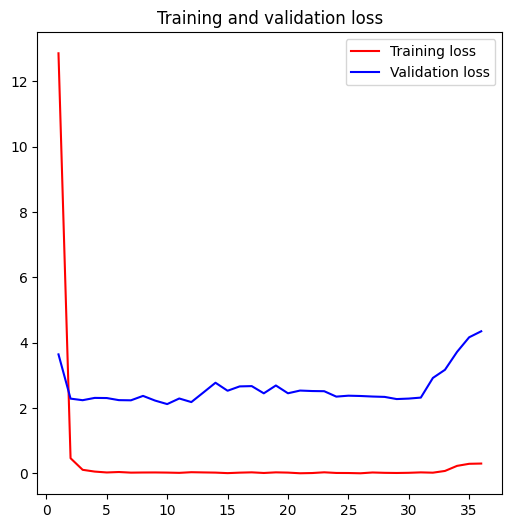

In [ ]:
display_plots(history)

1/1 [==============================] - 0s 467ms/step
100.00% 	 Siberian_husky
0.00% 	 Tibetan_mastiff
0.00% 	 Samoyed
0.00% 	 Great_Pyrenees
0.00% 	 malamute


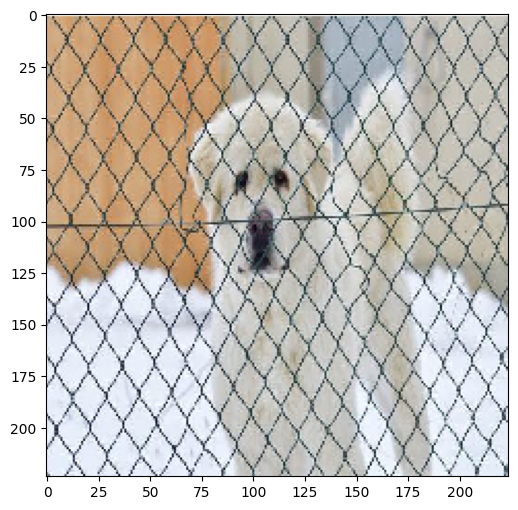

In [ ]:
predict_sample(img_height, img_width, model)

## Implémentation du modele préentrainé VGG16 sur le dataset complet images en 224x224 sans gel des couches (recalcul des poids de toutes les couches)

In [ ]:
%cd /content/drive/MyDrive/OpenClassRooms/Projet n°6/

/content/drive/MyDrive/OpenClassRooms/Projet n°6


In [ ]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 224
img_width = 224
epochs = 100
fit_verbosity=1
train_path = "./Images"
model_name = "VGG16pre0gel"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    validation_split=0.2)

valid_datagen = ImageDataGenerator(
    rescale= 1./255,
    validation_split = 0.2)

In [ ]:
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle= None,
    subset='training'
)

val_ds = valid_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle= None,
    subset='validation'
)

Found 16552 images belonging to 120 classes.
Found 4082 images belonging to 120 classes.


In [ ]:
X, labels = val_ds.next()
class_val = {v: k for k, v in val_ds.class_indices.items()}
num_classes = len(class_val)

In [ ]:
import pickle
filename = 'labels.pickle'
pickle.dump(class_val, open(filename, 'wb'))

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height,3))
#for layer in base_model.layers:
#  layer.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
x = keras.layers.BatchNormalization()(base_model.output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

In [ ]:
foldername = 'Images'
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/VGG16pre0gel_Images_224x224/


In [ ]:
%%time
t0 = time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100
518/518 [==============================] - 15199s 29s/step - loss: 4.8113 - accuracy: 0.0079 - val_loss: 4.7892 - val_accuracy: 0.0066
Epoch 2/100
518/518 [==============================] - 368s 709ms/step - loss: 4.7896 - accuracy: 0.0079 - val_loss: 4.7879 - val_accuracy: 0.0088
Epoch 3/100
518/518 [==============================] - 363s 700ms/step - loss: 4.7889 - accuracy: 0.0077 - val_loss: 4.7875 - val_accuracy: 0.0076
Epoch 4/100
518/518 [==============================] - 363s 701ms/step - loss: 4.7882 - accuracy: 0.0087 - val_loss: 4.7872 - val_accuracy: 0.0073
Epoch 5/100
518/518 [==============================] - 363s 700ms/step - loss: 4.7882 - accuracy: 0.0087 - val_loss: 4.7877 - val_accuracy: 0.0103
Epoch 6/100
518/518 [==============================] - 364s 702ms/step - loss: 4.7879 - accuracy: 0.0094 - val_loss: 4.7868 - val_accuracy: 0.0083
Epoch 7/100
518/518 [==============================] - 360s 695ms/step - loss: 4.7876 - accuracy: 0.0091 - val_loss: 4

## Implémentation du modele Xception

In [6]:
%cd /content/drive/MyDrive/OpenClassRooms/Projet n°6/

/content/drive/MyDrive/OpenClassRooms/Projet n°6


In [7]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 299
img_width = 299
epochs = 50
fit_verbosity=1
train_path = "./Images"
model_name = "Xception"

In [8]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    validation_split=0.2)

valid_datagen = ImageDataGenerator(
    rescale= 1./255,
    validation_split = 0.2)

In [9]:
train_ds = train_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle= None,
    subset='training'
)

val_ds = valid_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle= None,
    subset='validation'
)

Found 16552 images belonging to 120 classes.
Found 4082 images belonging to 120 classes.


In [10]:
X, labels = val_ds.next()
class_val = {v: k for k, v in val_ds.class_indices.items()}

In [12]:
import pickle
filename = 'labels.pickle'
pickle.dump(class_val, open(filename, 'wb'))

In [11]:
from tensorflow.keras.applications.xception import Xception, preprocess_input
base_model = Xception(include_top=False,
                  input_shape = (img_height,img_width,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [12]:
num_classes = len(val_ds.class_indices)
x = keras.layers.BatchNormalization()(base_model.output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [13]:
foldername = 'Images'
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/Xception_Images_299x299/


In [14]:
adamOpti = Adam(learning_rate=0.0001)
model.compile(optimizer = adamOpti, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [15]:
%%time
t0 = time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/50
518/518 [==============================] - 1425s 3s/step - loss: 5.3317 - accuracy: 0.0053 - val_loss: 4.2322 - val_accuracy: 0.1815
Epoch 2/50
518/518 [==============================] - 408s 788ms/step - loss: 4.9716 - accuracy: 0.0164 - val_loss: 3.4712 - val_accuracy: 0.5250
Epoch 3/50
518/518 [==============================] - 409s 788ms/step - loss: 4.8203 - accuracy: 0.0338 - val_loss: 2.7896 - val_accuracy: 0.6472
Epoch 4/50
518/518 [==============================] - 410s 792ms/step - loss: 4.6902 - accuracy: 0.0602 - val_loss: 2.1931 - val_accuracy: 0.7171
Epoch 5/50
518/518 [==============================] - 413s 796ms/step - loss: 4.5381 - accuracy: 0.0915 - val_loss: 1.7483 - val_accuracy: 0.7403
Epoch 6/50
518/518 [==============================] - 400s 772ms/step - loss: 4.4200 - accuracy: 0.1191 - val_loss: 1.4389 - val_accuracy: 0.7621
Epoch 7/50
518/518 [==============================] - 405s 782ms/step - loss: 4.2807 - accuracy: 0.1432 - val_loss: 1.2477 - v

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/models/best-model.h5")

In [16]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
bench_file = './Run/models/bench_models.csv'
df_bench = pd.read_csv(bench_file)
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
pd.DataFrame(df_bench).to_csv(bench_file, index=False)
df_res

Max validation accuracy is : 0.8030


Modele  Folder   Format  Durée  Accuracy  Epoch_max
0  Xception  Images  299x299  354.0  0.803038         50

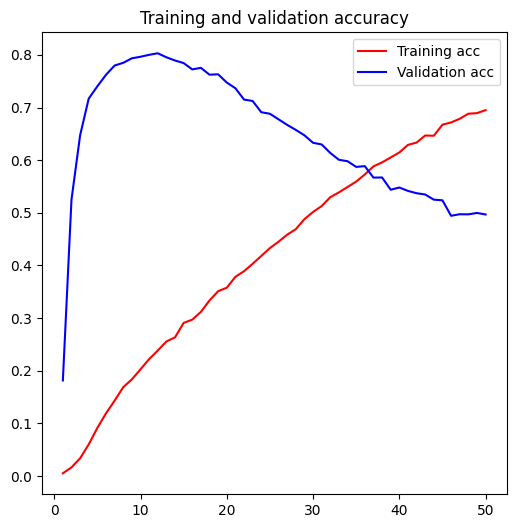

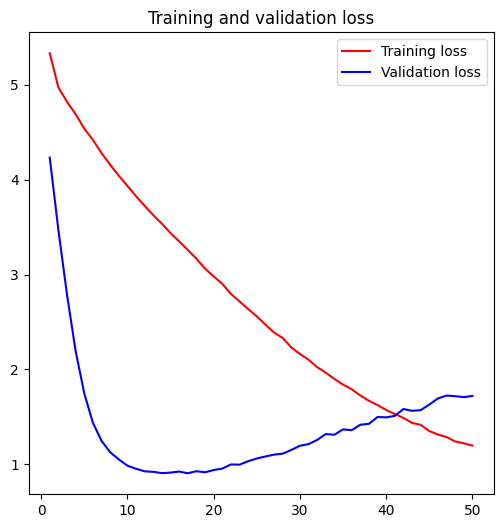

In [17]:
display_plots(history)

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/models/model-model.h5")

In [18]:
#Confution Matrix and Classification Report
num_of_train_samples = train_ds.samples
num_of_test_samples = val_ds.samples
Y_pred = model.predict_generator(val_ds, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_ds.classes, y_pred))
print('Classification Report')
target_names = list(train_ds.class_indices.keys())
print(classification_report(val_ds.classes, y_pred, target_names=target_names))

<ipython-input-18-e34ff8ccc3d5>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_ds, num_of_test_samples // batch_size+1)


Confusion Matrix
[[ 6  0  0 ...  0  0  0]
 [ 0 32  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ... 23  1  0]
 [ 0  0  0 ...  1 28  0]
 [ 0  0  0 ...  1  1 28]]
Classification Report
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.67      0.20      0.31        30
              n02085782-Japanese_spaniel       0.50      0.86      0.63        37
                   n02085936-Maltese_dog       0.20      0.02      0.04        50
                      n02086079-Pekinese       0.86      0.41      0.56        29
                      n02086240-Shih-Tzu       0.42      0.40      0.41        42
              n02086646-Blenheim_spaniel       0.58      0.19      0.29        37
                      n02086910-papillon       0.76      0.82      0.79        39
                   n02087046-toy_terrier       0.34      0.88      0.49        34
           n02087394-Rhodesian_ridgeback       0.29      0.59     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
import pickle
class_names = pickle.load(open("labels.pickle", "rb"))

1/1 [==============================] - 0s 24ms/step
85.44% 	 dhole
12.10% 	 dingo
0.37% 	 German_shepherd
0.22% 	 malinois
0.19% 	 kelpie


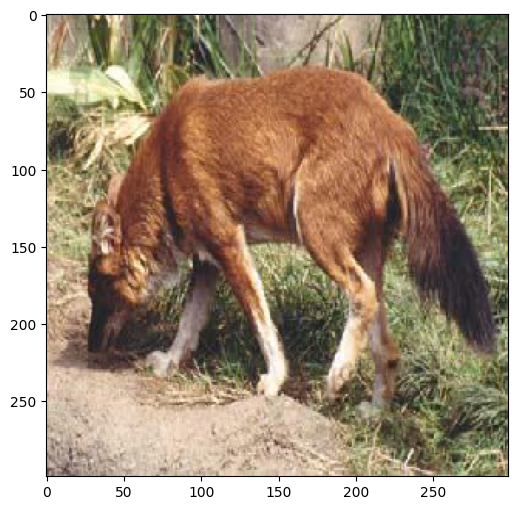

In [21]:
from keras.utils import img_to_array
from keras.utils import load_img
img = load_img("/content/drive/MyDrive/OpenClassRooms/Projet n°6/Images/n02115913-dhole/n02115913_1010.jpg", target_size=[299, 299])
plt.imshow(img)
input_array = np.reshape(img_to_array(img), (-1, 299, 299, 3)) / 255

pred = model.predict(input_array)
for idx in pred.argsort()[0][::-1][:5]:
  print("{:.2f}%".format(pred[0][idx]*100), "\t", class_names[idx].split("-")[-1])

In [ ]:
# Test même configuration mais avec 100 epochs pour voir l'évolution de la précision du validation set

In [11]:
%cd /content/drive/MyDrive/OpenClassRooms/Projet n°6/

/content/drive/MyDrive/OpenClassRooms/Projet n°6


In [3]:
# Initialisation
tf.keras.backend.clear_session()
batch_size = 32
img_height = 299
img_width = 299
epochs = 100
fit_verbosity=1

In [4]:
train_path = "./ImagesClf"
model_name = "Xception-"

In [12]:
foldername = "ImagesClf"
train_ds, val_ds, test_ds = create_datasets(foldername, img_height, img_width, batch_size )

# Etiquettes des classes cibles
class_names = train_ds.class_names
num_classes = len(class_names)
print (num_classes)

Found 15435 files belonging to 120 classes.
Found 3033 files belonging to 120 classes.
Found 2166 files belonging to 120 classes.
120


In [13]:
# Mise en cache pour accelerer les passages aux diffentes epochs
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback, checkpoint_callback = describe_callbacks(model_name, foldername, img_height, img_width)

To run tensorboard :
tensorboard --logdir /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/Xception-_ImagesClf_299x299/


In [16]:
from tensorflow.keras.applications.xception import Xception, preprocess_input
base_model = Xception(include_top=False,
                  input_shape = (img_height,img_width,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [17]:
x = keras.layers.BatchNormalization()(base_model.output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [18]:
adamOpti = Adam(learning_rate=0.0001)
model.compile(optimizer = adamOpti, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
%%time
t0 = time()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs= epochs,
  callbacks=[tensorboard_callback, bestmodel_callback, stopmodel_callback, savemodel_callback]
  #callbacks=[bestmodel_callback, stopmodel_callback, savemodel_callback]
)

Epoch 1/100
483/483 [==============================] - 1919s 898ms/step - loss: 4.8563 - accuracy: 0.0139 - val_loss: 4.7001 - val_accuracy: 0.0343
Epoch 2/100
483/483 [==============================] - 140s 291ms/step - loss: 4.6987 - accuracy: 0.0289 - val_loss: 4.6393 - val_accuracy: 0.0409
Epoch 3/100
483/483 [==============================] - 139s 288ms/step - loss: 4.5875 - accuracy: 0.0415 - val_loss: 4.5976 - val_accuracy: 0.0429
Epoch 4/100
483/483 [==============================] - 140s 289ms/step - loss: 4.5077 - accuracy: 0.0489 - val_loss: 4.5742 - val_accuracy: 0.0465
Epoch 5/100
483/483 [==============================] - 140s 289ms/step - loss: 4.4367 - accuracy: 0.0558 - val_loss: 4.5386 - val_accuracy: 0.0485
Epoch 6/100
483/483 [==============================] - 139s 289ms/step - loss: 4.3698 - accuracy: 0.0646 - val_loss: 4.5250 - val_accuracy: 0.0475
Epoch 7/100
483/483 [==============================] - 139s 289ms/step - loss: 4.3014 - accuracy: 0.0744 - val_loss: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/execution.py", line 1335, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 2, in <module>
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorboard/plugins/histogram/summary_v2.py", line 196, in histogram
    return tf.summary.write(
tensorflow.python.framework.errors_impl.FailedPreconditionError: {{function_node __wrapped__WriteSummary_device_/job:localhost/replica:0/task:0/device:CPU:0}} /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/Xception-_ImagesClf_299x299/train/events.out.tfevents.1687499641.c3860f0126f7.2321.0.v2; Transport endpoint is not connected
	Failed to flush 11 events to /content/drive/MyDrive/OpenClassRooms/Projet n°6/Run/logs/Xception-_ImagesClf_299x299/train/events.out.tfevents.16

In [ ]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

# Mémorisation des résultats
bench_file = './Run/models/bench_models.csv'
df_bench = pd.read_csv(bench_file)
df_res = pd.DataFrame([[model_name, foldername, str(img_height) + "x" + str(img_width) , round((time() - t0)/60,0), max_val_accuracy, len(history.history['accuracy'])]],
                       columns = ['Modele', 'Folder', 'Format', 'Durée', 'Accuracy', 'Epoch_max'])
df_bench = pd.concat([df_bench,df_res],ignore_index=True)
pd.DataFrame(df_bench).to_csv(bench_file, index=False)
df_res

In [ ]:
display_plots(history)

# Synthèse des résultats

In [ ]:
%cd /content/drive/MyDrive/OpenClassRooms/Projet n°6/

/content/drive/MyDrive/OpenClassRooms/Projet n°6


In [ ]:
bench_file = './Run/models/bench_models.csv'
df_bench = pd.read_csv(bench_file)

In [ ]:
df_bench

Modele            Folder   Format  Durée  Accuracy  Epoch_max
0     VGG16         FewBreeds  180x180   22.0  0.101587         16
1     VGG16  FewCroppedImages  180x180   23.0  0.102564         20
2  VGG16FT2         FewBreeds  224x224   11.0  0.688889         36
3  Xception           Images"  224x224   72.0  0.765079        100
4    VGG16+         FewBreeds  224x224    0.0  0.660317         20
5  VGG16aug         FewBreeds  224x224   22.0  0.082540         39
6  VGG16aug         FewBreeds  224x224   29.0  0.082540         39
7  Xception            Images  299x299  108.0  0.796825        100
8  Xception            Images  299x299  252.0  0.796423         25
9  Xception            Images  299x299  495.0  0.798138         50

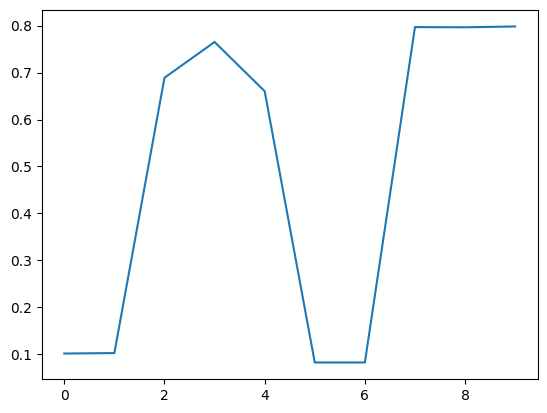

In [ ]:
plt.plot(df_bench.Accuracy)